In [1]:
!nvidia-smi

Tue Jul  4 06:45:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                  Off |
| N/A   27C    P0    41W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

#pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/fastmri4/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.25.1
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
cropped_size = 170

directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "cropped/" + str(cropped_size) + str(cropped_size) + str(cropped_size//2)

In [4]:
#!pip install openpyxl

patient_data = pd.read_excel("new_dataload.xlsx", usecols=['File_Name', 'MVI']).set_index('File_Name')
print(patient_data)

                MVI
File_Name          
0007739.nii.gz    1
0020491.nii.gz    1
0050368.nii.gz    0
0059047.nii.gz    0
0063193.nii.gz    1
...             ...
349.nii.gz        0
350.nii.gz        1
351.nii.gz        1
352.nii.gz        1
355.nii.gz        1

[494 rows x 1 columns]


In [5]:
import random

train_images = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))
train_labels = [patient_data.loc[os.path.basename(x), "MVI"] for x in train_images]
train_labels = torch.nn.functional.one_hot(torch.as_tensor(train_labels)).float()
data_list = list(zip(train_images, train_labels))
random.shuffle(data_list)
data_dicts = [{"image": image, "label": label} for image, label in data_list]
print(len(data_dicts))
print(data_dicts[0])

475
{'image': 'cropped/17017085/0100051.nii.gz', 'label': tensor([1., 0.])}


In [6]:
train_files, val_files = data_dicts[:400], data_dicts[400:]
set_determinism(seed=0)

In [7]:
def nii_loader(filename) :
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    nimg = nib.load( filename )
    return nimg.get_fdata() , nimg.affine, nimg.header 

def visualize(dataset, idx=0):
    import matplotlib.pyplot as plt    

    image = dataset[idx]['image']
    label = dataset[idx]['label']
    image_data, image_affine, image_header = nii_loader(image)
    
    print('[file path]', image)
    print('[dimension]', image_data.shape)
    print('[label]', label)
    target_image = image_data[:,:,image_data.shape[2]//2]

    plt.imshow(target_image, cmap='gray' )
    plt.show()
    return tuple(image_data.shape)

[file path] cropped/17017085/0099742.nii.gz
[dimension] (170, 170, 85)
[label] tensor([0., 1.])


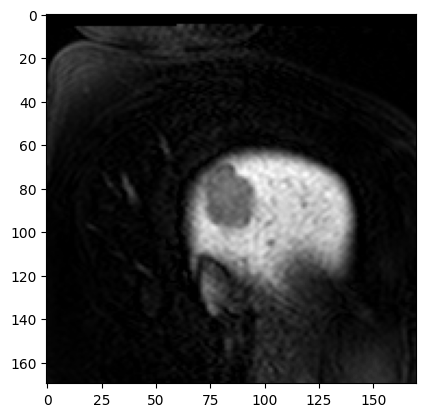

In [8]:
spatial_size = visualize(val_files, idx=1)

In [9]:
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    AddChanneld,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandAffined,
    SpatialPadd,
    EnsureTyped,
)

In [10]:
# ScaleIntensityRanged min/max differ by organs
# for liver, min = 30 + 150/2 = 105, max = 30 - 150/2 = -45
# see more info here https://radiopaedia.org/articles/windowing-ct

from monai.transforms import Compose

train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #AddChanneld(keys=["label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        #ScaleIntensityRanged(keys=["image"], a_min=-45, a_max=105, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
        RandAffined(
            keys=["image"],
            mode=("bilinear"),
            prob=1.0, spatial_size=spatial_size,
            rotate_range=(0, 0, 0),
            scale_range=(0, 0, 0)),
        SpatialPadd(keys=["image"], spatial_size=spatial_size),
        EnsureTyped(keys=["image"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #AddChanneld(keys=["label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        #ScaleIntensityRanged(keys=["image"], a_min=-45, a_max=105, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=spatial_size),
        EnsureTyped(keys=["image"]),
    ]
)

image shape: torch.Size([170, 170, 85]), label shape: torch.Size([])


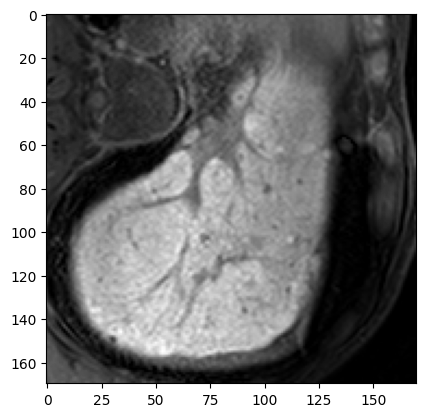

In [11]:
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism

check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

plt.imshow(image[:, :, spatial_size[2]//2], cmap="gray")
plt.show()

In [12]:
from monai.data import CacheDataset, DataLoader

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4, progress=True)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4, progress=True)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

Loading dataset: 100%|██████████████████████████| 75/75 [00:08<00:00,  8.96it/s]


In [13]:
from monai.networks.nets import DenseNet264

device = torch.device("cuda:0")
model = DenseNet264(
    spatial_dims=3,
    in_channels=1,
    out_channels=2
).to(device)

In [14]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
max_epochs = 100
val_interval = 1
save_interval = 10
best_score = -1
best_score_epoch = -1
epoch_loss_values = []
metric_values = []
model_name = 'Densenet264_' + str(spatial_size[0])

In [15]:
%%time

import time

for epoch in range(max_epochs):
    tic_epoch = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 5 ==0:
            print(f"\nepoch {epoch + 1}/{max_epochs} steps {step}/{len(train_ds) // train_loader.batch_size}, |train-loss: {loss.item():.4f}", end='')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    toc_epoch = time.time()
    dur_epoch = toc_epoch - tic_epoch
    print(f" |avg-loss: {epoch_loss:.4f} dur {dur_epoch:.1f}s ", end='')

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_count = 0
        val_correct = 0.0
        
        with torch.no_grad():
            for val_data in val_loader:
                inputs, labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                outputs = model(inputs)
                val_result = torch.eq(outputs.argmax(dim=1), labels.argmax(dim=1))
                val_count += len(val_result)
                val_correct += val_result.sum().item()
            
            val_score = val_correct / val_count
            metric_values.append(val_score)
            print(f"|val-acc: {val_score:.4f} |old-best: {best_score:.4f} " , end="")
            
            if val_score > best_score:
                best_score = val_score
                best_score_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_best.pth".format(model_name)))
                torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_best.pth".format(model_name)))
                print("|best model saved", end="")
    
    if (epoch+1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_{:04d}.pth".format(model_name, epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_{:04d}.pth".format(model_name, epoch+1)))
        print("|{}ep model saved".format(epoch+1), end='')
                            
print(f"\ntrain completed, best_metric: {best_score:.4f} at epoch: {best_score_epoch} for {max_epochs} epoches")


epoch 1/100 steps 5/200, |train-loss: 0.5321
epoch 1/100 steps 10/200, |train-loss: 1.1292
epoch 1/100 steps 15/200, |train-loss: 0.8464
epoch 1/100 steps 20/200, |train-loss: 0.8776
epoch 1/100 steps 25/200, |train-loss: 0.5117
epoch 1/100 steps 30/200, |train-loss: 0.4995
epoch 1/100 steps 35/200, |train-loss: 0.7856
epoch 1/100 steps 40/200, |train-loss: 1.0446
epoch 1/100 steps 45/200, |train-loss: 1.0054
epoch 1/100 steps 50/200, |train-loss: 0.6028
epoch 1/100 steps 55/200, |train-loss: 0.5914
epoch 1/100 steps 60/200, |train-loss: 0.7652
epoch 1/100 steps 65/200, |train-loss: 0.7616
epoch 1/100 steps 70/200, |train-loss: 0.4856
epoch 1/100 steps 75/200, |train-loss: 1.2354
epoch 1/100 steps 80/200, |train-loss: 0.8087
epoch 1/100 steps 85/200, |train-loss: 0.7348
epoch 1/100 steps 90/200, |train-loss: 0.7749
epoch 1/100 steps 95/200, |train-loss: 0.7131
epoch 1/100 steps 100/200, |train-loss: 0.7946
epoch 1/100 steps 105/200, |train-loss: 0.5033
epoch 1/100 steps 110/200, |trai

In [16]:
!rm -rf pymp-*

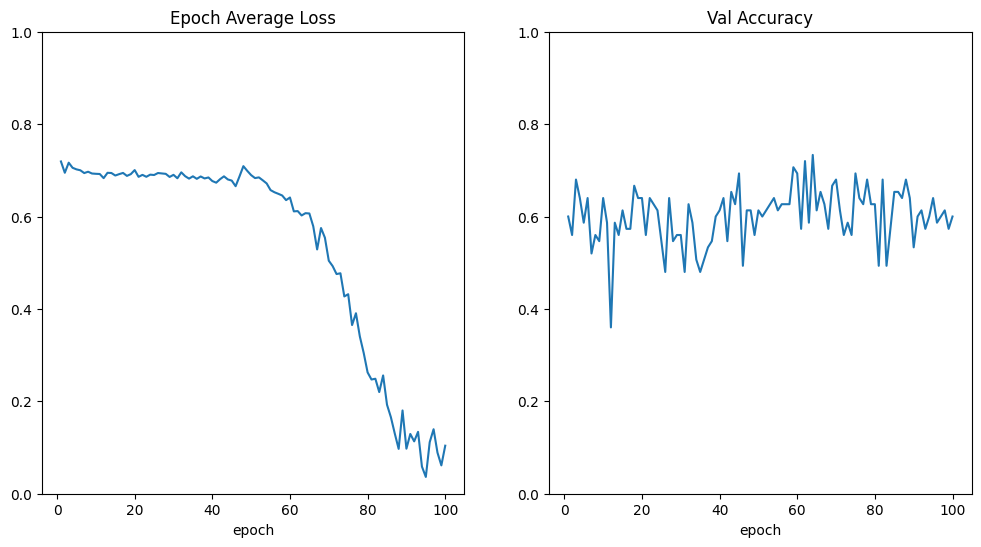

In [17]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.subplot(1, 2, 2)
plt.title("Val Accuracy")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.show()